In [1]:
#!pip install tensorflow-datasets
import os
from pathlib import Path
import cv2  # OpenCV for image processing-- read,write transform
import numpy as np  # image handling
from tensorflow.keras.datasets import mnist  # just the main bitch
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Pre-Processing




In [86]:
# To avoid unnessary code rewrite
df_train, df_test = tfds.load("omniglot", split=["train", "test"], as_supervised=True)
imgs, labels = [], []
for img, lab in tfds.as_numpy(df_train):
    imgs.append(img)
    labels.append(lab)
X = np.array(imgs)
y = np.array(labels)
# Dataset split
# https://stackoverflow.com/questions/47321709/how-to-split-train-and-test-dataset-to-x-train-y-train-and-x-test-y-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [82]:
# chat was referenceed
# https://chatgpt.com/share/68ca64d6-2fdc-800b-a487-24449f2bafa7
# MUSTR REFER TP OMN TJE RE[PRT
(x_train, y_train), (_, _) = mnist.load_data()


#
def mutiple_numbers(x, y, num_images, max_digits=10):
    imgs = []
    labels = []
    for i in range(num_images):
        digits_per_image = np.random.randint(1, max_digits + 1)
        ints = np.random.randint(0, len(x), digits_per_image)
        chosen_digits = [x[idx] for idx in ints]
        chosen_labels = [y[idx] for idx in ints]
        img = np.hstack(chosen_digits)
        imgs.append(img)
        labels.append(tuple(chosen_labels))
    return imgs, labels

In [93]:
## BASE_DIR = Path(os.getcwd())


#
OUT_DIR = BASE_DIR / "Preprocessed"
OUT_DIR.mkdir(parents=True, exist_ok=True)


# preprocessing function area
def preprocess_single(
    img_bgr, out_size=128, pad=10
):  # expect 3channel BGR image- out size as 128x 128 pixel pad is just padding
    """
    Preprocess one image:
    1. Convert to grayscale
    2. Threshold to binary (digits white on black)
    3. Crop -> center pad -> resize to out_size (default 128x128)
    Returns: preprocessed image (uint8)
    """
    # --- Grayscale ---
    gray = cv2.cvtColor(
        img_bgr, cv2.COLOR_BGR2GRAY
    )  # convert 3 channel BGR to 1 channel grayscale IN DOCUMENTATION REPORT LOGIC IS MOST DIGIT REC MODESL DONT NEED COLOUR
    # There was a issue with loading Mnist from keras, and using opencv  as it expected 8bit grayscale
    # gray was a float not a uint8 so i had to convert it so opencv would accept it
    if gray.dtype != "uint8":
        gray = (gray * 255).astype("uint8")

    # --- Adaptive threshold (digits white on black) ---
    bw = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 10
    )  # works like this: Convert to gray-> use a adaptive threshold to handle any uneven lighting(The simple thres was a asshole to work with) the thresh binary part inverts images so digits become WHITE(THIS IS A COMMON PRACTISE IN MACHINE LEARNING LOOK AT PAPER E4)
    """Remeber BW= Binary image ys=row indices of white pixels and xs= column indices of white pixels"""

    # --- Tight crop around digits ---
    ys, xs = np.where(bw > 0)
    if xs.size and ys.size:
        x0, x1 = xs.min(), xs.max()  # left edge of digit, right edge of digit
        y0, y1 = ys.min(), ys.max()  # top edge of digit, bottom edge of digit
        tight = bw[
            y0 : y1 + 1, x0 : x1 + 1
        ]  # Removes all unnessary black background and focuses only on the digit by cropping the image to the defined rectangle
    else:
        tight = bw  # Troubleshooter ensures array always returns even if none found

    # --- Center pad to square ---
    digit_height, digit_width = tight.shape
    canvas_side = max(digit_height, digit_width) + 2 * pad
    padded_canvas = np.zeros(
        (canvas_side, canvas_side), dtype=np.uint8
    )  # make the empty
    # offset calculations to center on the canvas
    yoffset = (canvas_side - digit_height) // 2
    xoffset = (canvas_side - digit_width) // 2
    padded_canvas[yoffset : yoffset + digit_height, xoffset : xoffset + digit_width] = (
        tight
    )
    # --- Resize to fixed size (default 128x128) ---
    resized = cv2.resize(
        padded_canvas, (out_size, out_size), interpolation=cv2.INTER_AREA
    )  # resize to 128x128 and the inter-area acts like scale feature in css,
    return resized
    # ML models need consistent image sizing that is why it is resized that is important mention report in basic part.
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    # ADDED ONE HOT ENCODING--------vital for bin
    y_train_cat = to_categorical(y_train, num_classes=10)
    y_test_cat = to_categorical(y_test, num_classes=10)


dataset_testing = int(input("Please select a dataset[0,1,2]1=Create new images"))
if dataset_testing == 0:
    # Load mnist  images and labels into training data
    # This will allow near 60k trainign images and around 10k test images, without having to use the kraggle repository and enaring with crosiant
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    print("Training Images: ", x_train.shape)  # x train is image of a digit
    print(
        "Training Labels: ", y_train.shape
    )  # y_train is the label of the digit aka 0-9

    # ---------- Run preprocessing and save----------
    which_nums_processing = 100  # SET TO 100 because its small  this is a test mech
    for i in range(which_nums_processing):
        # img_gray = x_train[i]#must be SQUARE LINES NOT THE BRACKETS OR ELSE IT WILL SAY OBECJT NOT CALLABLE!!!!!
        #  img_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR) #convert to BGR so its compatible with the preprocesser function
        # send to preprocess
        img = x_train[i]
        if len(img.shape) == 2:  # grayscale
            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif len(img.shape) == 3 and img.shape[2] == 3:  # already BGR/RGB
            img_bgr = img.copy()
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")
        pre_img = preprocess_single(img_bgr, out_size=128)  # <--- made images bigger
        # Save output PNG
        out_png = OUT_DIR / f"img_{i}_preprocessed.png"
        cv2.imwrite(out_png, pre_img)
        print(f"[OK] Image {i}: saved {out_png}")

if dataset_testing == 1:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    num_images = int(input("Please choose how many images"))
    
    imgs, labels = mutiple_numbers(x_train, y_train, num_images, max_digits=10)
    # Visualize only 4
    for i, img in enumerate(imgs):
        # pre_img = img.astype(np.uint8)
        pre_img = (
            (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
        )
        out_png = OUT_DIR / f"img_{i}_preprocessed.png"
        cv2.imwrite(str(out_png), pre_img)


elif dataset_testing == 2:
    # To avoid unnessary code rewrite
    df_train, df_test = tfds.load(
        "omniglot", split=["train", "test"], as_supervised=True
    )
    x_train, y_train = [], []
    for img, lab in tfds.as_numpy(df_train):
        x_train.append(img)
        y_train.append(lab)
    x_train, y_train = np.array(x_train), np.array(y_train)

    # append img and labels to test instances
    x_test, y_test = [], []

    for img, lab in tfds.as_numpy(df_test):
        x_test.append(img)
        y_test.append(lab)
x_test, y_test = np.array(x_test), np.array(y_test)
# Dataset split
# https://stackoverflow.com/questions/47321709/how-to-split-train-and-test-dataset-to-x-train-y-train-and-x-test-y-test


# this is incomplete
def preprocess_letters(img, out=28):
    # resize
    img_resized = cv2.resize(img, (out, out))
    # grayscale convert
    if len(img_resized.shape) == 3 and img_resized.shape[-1] == 3:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    # normalize 0-1
    img_resized = img_resized.astype("float32") / 255.0
    return img_resized

    
    x_train = np.array([preprocess_letters(img) for img in x_train])
    x_test = np.array([preprocess_letters(img) for img in x_test])


# Loop over extensions, Build path, check file exists, return if path found else return none


def find_image(idx):
    """Return path for numbered file with common extensions."""
    for ext in (".jpg", ".jpeg", ".png", ".webp"):
        p = os.path.join(BASE_DIR, f"{idx}{ext}")
    ##      return p
    return None


print(f"\nTask 1 complete! Preprocessed images are in: {OUT_DIR}")

Please select a dataset[0,1,2]1=Create new images 1
Please choose how many images 10



Task 1 complete! Preprocessed images are in: C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Preprocessed


In [ ]:
# CLEAN AND PREPROCESS THE DATA

#Segmentation


In [198]:
BASE_DIR = Path(os.getcwd())
IN_DIR = BASE_DIR / "Preprocessed"
OUT_DIR = BASE_DIR / "segmentation"

IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)


# Contour segmentation
def segment_contours(bw, dilate_kernel=(3, 3), min_area=30):
    dil = cv2.dilate(bw, cv2.getStructuringElement(cv2.MORPH_RECT, dilate_kernel), 1)
    contours, _ = cv2.findContours(dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h >= min_area and h > 6 and w > 3:
            boxes.append((x, y, w, h))
    return sorted(boxes, key=lambda b: b[0])


# --- Splitter for wide blobs ---
def projection_split(sub_bw, min_run=6):
    v = (sub_bw.sum(axis=0) > 0).astype(np.uint8)
    runs, start = [], None
    for i, val in enumerate(v):
        if val and start is None:
            start = i
        if not val and start is not None:
            if i - start >= min_run:
                runs.append((start, i))
            start = None
    if start is not None and len(v) - start >= min_run:
        runs.append((start, len(v)))
    return runs


# --- Main segmentation ---
def segment_digits(img_gray):
    # --- Binarize ---
    _, bw = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    boxes = segment_contours(bw)

    refined = []
    rois = []  # cropped regions of interest (digits)

    for x, y, w, h in boxes:
        # If the box is much wider than the height, try splitting
        if w > 1.5 * h:
            sub = bw[y:y+h, x:x+w]
            splits = projection_split(sub, min_run=6)

            if len(splits) >= 2:
                for sx, ex in splits:
                    refined.append((x+sx, y, ex-sx, h))
                    roi = img_gray[y:y+h, x+sx:x+ex]
                    rois.append(roi)
                continue

        refined.append((x, y, w, h))
        rois.append(img_gray[y:y+h, x:x+w])

    # sort boxes left-to-right
    refined = sorted(refined, key=lambda b: b[0])

    # visualize boxes
    vis = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in refined:
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

    return refined, vis, rois


# --- Run on all Task 1 images ---
for fname in os.listdir(IN_DIR):
    if not fname.lower().endswith(".png"):
        continue
    path = os.path.join(IN_DIR, fname)
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    boxes, vis,rois= segment_digits(img_gray)
    base = os.path.splitext(fname)[0]

    out_path = os.path.join(OUT_DIR, f"{base}_boxes.png")
    cv2.imwrite(out_path, vis)

    print(f"[OK] {fname}: {len(boxes)} digits detected → {out_path}")

print("\nTask 2 complete. Overlays with thin boxes saved in:", OUT_DIR)

[OK] img_0_preprocessed.png: 8 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_0_preprocessed_boxes.png
[OK] img_10_preprocessed.png: 5 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_10_preprocessed_boxes.png
[OK] img_11_preprocessed.png: 1 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_11_preprocessed_boxes.png
[OK] img_1_preprocessed.png: 10 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_1_preprocessed_boxes.png
[OK] img_2_preprocessed.png: 7 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_2_preprocessed_boxes.png
[OK] img_3_preprocessed.png: 1 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_3_preprocessed_boxes.png
[OK] img_4_preprocessed.png: 8 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_4_pre

# Detection Test Printing Random Number 

(60000, 28, 28) (60000,)
1


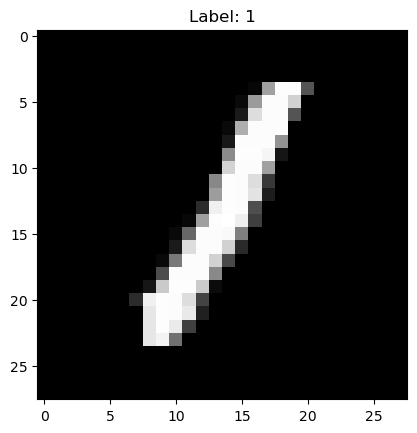

In [19]:
# test The printing
BASE_DIR = Path(os.getcwd())
IN_DIR = BASE_DIR / "Segmentation"
OUT_DIR = BASE_DIR / "Detected"

IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)


# Output the image and label to screen
import matplotlib.pyplot as plt

import random

random_i = random.randint(0, 999)

print(x_train.shape, y_train.shape)  # print shape
plt.imshow(x_train[random_i], cmap="gray")  # See the first digit
plt.title(f"Label: {y_train[random_i]}")
print(f"{y_train[random_i]}")
plt.show()
# This part above might be good for gui

# Digit Detection


In [115]:
# Mutiple layer perception
# connected neural net
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense


def Multiple_Layer_Perceptron(input_shape):
    name = "Multiple_Layer_Perceptron"
    # The yes/no decision layer stack
    model = Sequential(name=name)

    model.add(
        Flatten(input_shape=input_shape)
    )  # turn into 1 flat layer aka 28 x 28 in line of 784 pix instead of grid
    model.add(
        Dense(128, activation="relu")
    )  # rectafy liner unit keep pos kill neg------this si the first hidden layer
    model.add(Dense(64, activation="relu"))  # second hidden layer
    model.add(
        Dense(10, activation="softmax")
    )  # Output layer, 10 neurons--all outputs must + to get 1
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()
    # model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=['accuracy'])
    # model.fit(x_train,y_train)
    # hamTest=eval_model(model,x_test,y_test,"MLP")
    return model


Multiple_Layer_Perceptron((28, 28))

# Reinforcement and supervision learning test

Model: "Multiple_Layer_Perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=Multiple_Layer_Perceptron, built=True>

⚡ Training model...
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8363 - loss: 0.5724 - val_accuracy: 0.9750 - val_loss: 0.0793
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9784 - loss: 0.0700 - val_accuracy: 0.9872 - val_loss: 0.0465
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9852 - loss: 0.0479 - val_accuracy: 0.9878 - val_loss: 0.0436
🔎 0 digits detected


In [449]:
# cnn
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential


def Convolutional_Neural_Network(input_shape):
    name = "Convolutional_Neural_Network"
    model = keras.Sequential(
        [
            Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
        ],
        name=name,
    )

    model.summary()


Convolutional_Neural_Network((28, 28))

Model: "Convolutional_Neural_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [192]:
##Section from earlier to refer to def segment_digits(img_gray):
#Test which Image is being read


'''
The followng is a explaination of what the boxes are In case you remember you dont remember

The boxes from earlier are from the segment digits function 
which works by seperating imgs that are wider then they are tall
into sections that are 28 x 28(pretty much)
So like this
X=where box starts horizionally/LEFT TO RIGHT
Y=Where the box starts vertically/TOP TO BOTTOM
W=box width
H=Box Height
AKA may look like
these typles

[(6,3,17,22),(32,3,20,22)]etc
HE BOXES STORE THE INSTRUCTIONS AS TO WHERE!!!! O FIND THE PIXELS IN THE IMG

ROI is the region of Intrest think cropped digit in the bx
Overall the imshow
 it just displays th croped out dig

take the big picture cut out therectangle with hte digit and sho wme that part



'''
i=input("enter")
fname=8
print(f"[OK] {fname}: {len(boxes)} digits detected → {out_path}")
for i, box in enumerate(boxes):#Loop over each of te boxes one by one
    x,y,w,h=box#unpack the coords NEVER DELETE THIS IT IS NEEDED!!!
    roi=img_gray[y:y+h,x:x+w]#Crop form the og img
    #Display each segmented box for testing,
    plt.figure()
    plt.imshow(roi, cmap="gray")
    plt.title(f"Box {i}: (x={x}, y={y}, w={w}, h={h})")
    plt.axis("off")
    plt.show()

enter 2


[OK] 8: 0 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\img_9_preprocessed_boxes.png


In [1]:
# This is the evalute model tester function
def eval_model(model, x_test, y_test, model_name="hambubgerV1"):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
    return accuracy

In [27]:
# Choose Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape


def Recurrent_Neural_Networks(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),  # Proper way to define input shape
            Reshape((28, 28)),  # reshape 28x28 image → sequence
            LSTM(128),  # LSTM layer
            Dense(32, activation="relu"),  # Output layer for 10 digits
            Dense(10, activation="softmax"),  # Output layer for 10 digits
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model.summary()
    return model


Recurrent_Neural_Networks((28, 28))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,842 (331.41 KB)

 Trainable params: 84,842 (331.41 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_1, built=True>

In [164]:
# reinforcement model
# model = multiple_layer_perceptron_model(x_train.shape[1:])

# For unknown reasons this code has decieded to be a asshole, please do not question why it will take vengeage
# Reinforcement Testing function is mostly for weird cases i dont really know when we would want it
from tensorflow.keras.utils import to_categorical
import numpy as np


def reinforcement(i, model, model_index, dataset, reinforce=True):
    print(f"Model index: {model_index}")

    # Select the correct image and true label
    if dataset == "test":
        img = x_test[i]
        true_label = y_test[i]
    else:
        img = x_train[i]
        true_label = y_train[i]

    # Expand dims for model input
    img_input = np.expand_dims(img, axis=0)  # shape: (1, 28, 28) or (1, 28, 28, 1)

    # Convert true_label to scalar if one-hot
    if isinstance(true_label, np.ndarray) and len(true_label.shape) > 0:
        truth_of_label_index = int(np.argmax(true_label))
    else:
        truth_of_label_index = int(true_label)

    # Predict label
    predicted_label = int(np.argmax(model.predict(img_input)))

    print(f"Predicted label: {predicted_label}")
    print(f"True label: {truth_of_label_index}")

    # Reinforce only if prediction is wrong
    if predicted_label != truth_of_label_index and reinforce:
        print("Incorrect! Updating model with correct label...")

        # Determine whether to use sparse or categorical
        if model.loss == "categorical_crossentropy":
            y_input = to_categorical([truth_of_label_index], num_classes=10)
        else:  # sparse_categorical_crossentropy
            y_input = np.array([truth_of_label_index])

        # Update model
        model.fit(img_input, y_input, epochs=1, verbose=0)
        print("Model updated!")

In [204]:
BASE_DIR = Path(os.getcwd())
IN_DIR = BASE_DIR / "Segmentation"
OUT_DIR = BASE_DIR / "Detected"

IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
# Fully connected neural net
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import backend as K

# The below is a calling method to test all of the types of models
# THIS DOES NOT INCLUDE TRAINING!!!! THIS IS TO TEST SPECFIC ONES

# Grab all PNGs in a sorted order
# img_full = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

#img_path = image_files[i]
# print(f"Reading image: {img_path}")  # <-- This shows exactly which PNG
# h, w = img_full.shape

BLOCK_SIZE = 28
block_count = 0

available_models = [
    "Pray",
    "Multi Layer Perception Model (MLPs)",
    "Convolutional Neural Networks (CNNs) ",
    "Deep Neural Networks (DNNs) ",
    "Recurrent Neural Networks (RNNs)",
]
which_model = int(
    input("Please select a model(0=default program, 1=MLP,2= CNN, 3=DNN, 4=RNN)")
)
print(f"You have selected: {available_models[which_model]}")
train_or_test = int(input("Please select a option(1=Test Model, 2=Train Model)"))
if train_or_test == 1:
    dataset = "test"
    reinforce = False
elif train_or_test == 2:
    dataset = "train"
    reinforce = True
else:
    print("I dont want to add another option")
K.clear_session()
index=0
match which_model:
    # Multi Layer Perception Model (MLPs)
    case 1:
        img_indexed = int(input("Please choose index between 0-900: "))
        if 0 <= img_indexed <= 900:
            img = x_test[img_indexed]
            true_label = y_test[img_indexed]
    
            # ensure grayscale
            if img.ndim == 3 and img.shape[-1] == 3:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            elif img.ndim == 3 and img.shape[-1] == 1:
                img_gray = img.squeeze()
            else:
                img_gray = img
    
            # convert to uint8 for OpenCV threshold
            if img_gray.dtype != np.uint8:
                img_gray = (img_gray * 255).astype(np.uint8)
    
            # segment
            boxes, vis, rois = segment_digits(img_gray)
            print(f"[OK] Test image #{img_indexed}: {len(boxes)} digits detected")
    
            for box_index, roi in enumerate(rois):
                plt.figure()
                plt.imshow(roi, cmap="gray")
                plt.title(f"Image {img_indexed}, Box {box_index}, True Label: {true_label}")
                plt.axis("off")
                plt.show()
    
                roi_resized = cv2.resize(roi, (28, 28)) / 255.0
                roi_resized = np.expand_dims(roi_resized, axis=(0, -1))
                pred = np.argmax(model.predict(roi_resized))
    
                print(f"Box {box_index}: Model predicts {pred}, True label: {true_label}")

    # Convolutional Neural Networks (CNNs)
    case 2:
        print(f"{available_models[which_model]}")
    #
    case 3:
        print(f"{available_models[which_model]}")
    # Recurrent Neural Networks (RNNs)
    # https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
    # This cheatsheet is the only way to understand what on earth the math is
    case 4:
        dataset = dataset
        img_indexed= int(input("Please choose index betwen 0-900: "))
        print(f"[OK] {fname}: {len(boxes)} digits detected → {out_path}")
        if 0 <= img_indexed <= 900:
            print(f"[OK] {fname}: {len(boxes)} digits detected → {out_path}")
            for img_indexed, box in enumerate(boxes):
                x,y,w,h=box#unpack the coords NEVER DELETE THIS IT IS NEEDED!!!
                roi=img_gray[y:y+h,x:x+w]#Crop form the og img
                img = x_test[index]
                true_label = y_test[index]
                # SHOW ME THE MONEY
                plt.imshow(img, cmap="gray")
                plt.title(f" Data test #{index} - True Label:{true_label}")
                plt.show()
    
                # For each Box detected Run the program
                # segmentation
    
                # Build the rnn model
                # MUST MAKE SURE THE THING IS PASSED AS TWO AGURMENTS INSTEAD OF ONE TUPLE . IE (28,28) IS WRONG but ((28,28)) is correct
                model = Recurrent_Neural_Networks(
                    x_train.shape[1:]
                )  # test mechs are x_train.shape[1:] or 28,28
                # train the model
                y_train_cat = to_categorical(y_train, num_classes=10)
                model.compile(
                    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
                )
                model.fit(x_train, y_train_cat, epochs=1, batch_size=128, verbose=1)
                # predict
    
                img_rnn = np.expand_dims(img, axis=0)
                predicted_label = np.argmax(model.predict(img_rnn))
    
                if len(np.shape(true_label)) > 0:  # one-hot
                    truth_of_label_index = int(np.argmax(true_label))
                else:
                    truth_of_label_index = int(true_label)
    
                y_input = to_categorical(
                    [truth_of_label_index], num_classes=10
                )  # shape (1, 10)
                print(f"Model predicts {predicted_label}")
                print(f"True label is: {truth_of_label_index}")
    
                if predicted_label != truth_of_label_index:
                    reinforcement(
                        i=index,
                        model=model,
                        model_index=4,
                        dataset=dataset,
                        reinforce=reinforce,
                    )
                else:
                    print("IT IS CORRECT")

    case _:
        print("You selected default or an invalid option.")

img_uint8 = (img * 255).astype(np.uint8)
filename = OUT_DIR / f"label_{index}_predicted_{truth_of_label_index}.png"
cv2.imwrite(str(filename), img_uint8)

print(f"saved image to {filename}")
# When testying try 54 its weird

Please select a model(0=default program, 1=MLP,2= CNN, 3=DNN, 4=RNN) 1


You have selected: Multi Layer Perception Model (MLPs)


Please select a option(1=Test Model, 2=Train Model) 1
Please choose index between 0-900:  2


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1559: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 6 (CV_64FC1)


Please choose index between 0 and 2:  1


Reading image: C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Segmentation\img_1_preprocessed_boxes.png


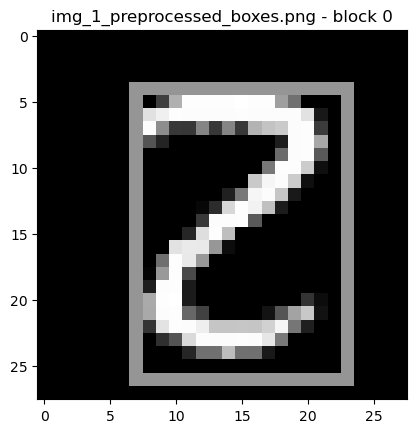

Saved block 0 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block0.png


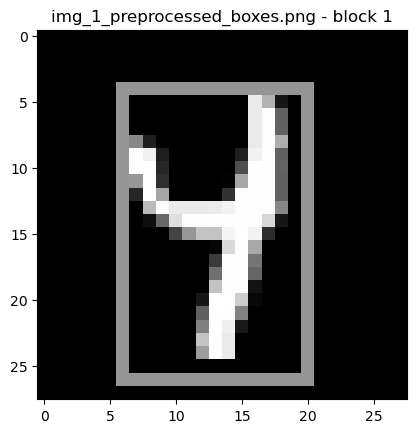

Saved block 1 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block1.png


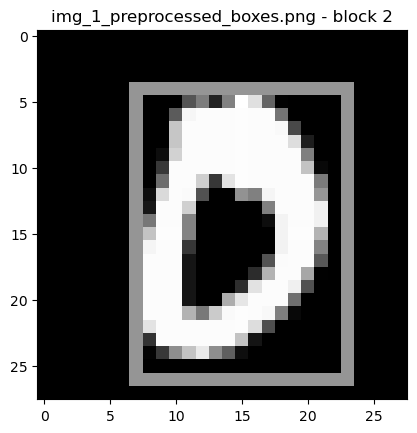

Saved block 2 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block2.png


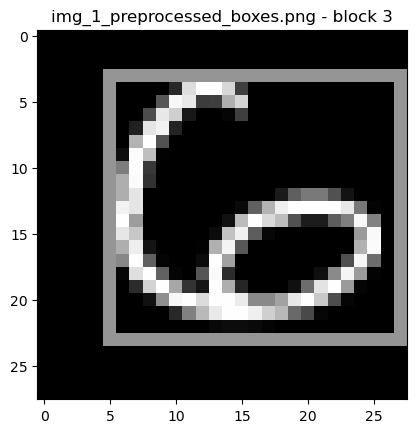

Saved block 3 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block3.png


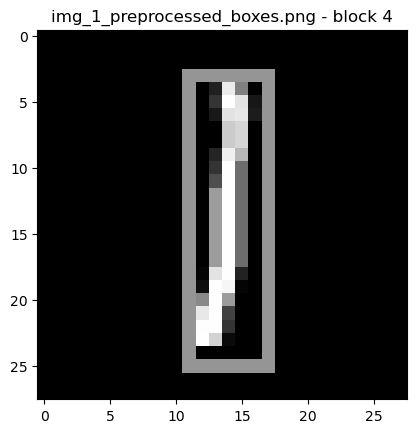

Saved block 4 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block4.png


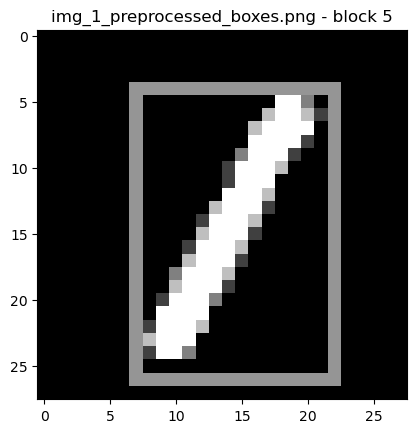

Saved block 5 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block5.png


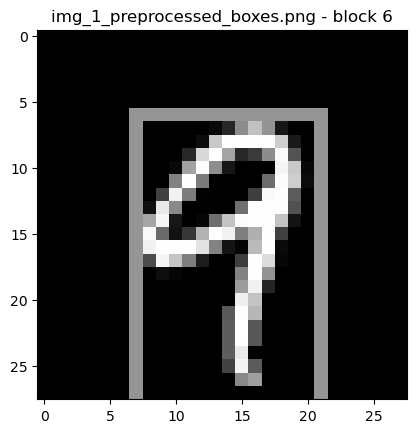

Saved block 6 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block6.png


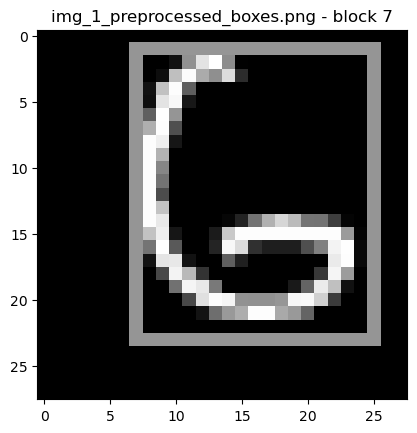

Saved block 7 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block7.png


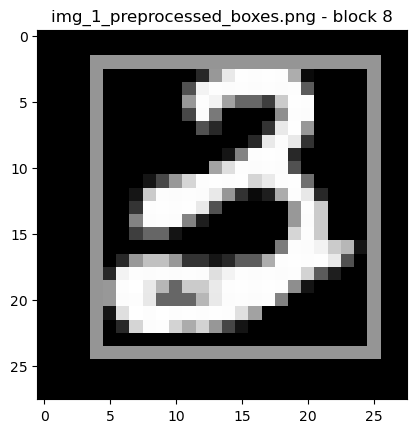

Saved block 8 to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\img_1_preprocessed_boxes_block8.png


In [ ]:
# This is for other detection

# Letter detection


In [ ]:
i=
def predict_letters(i,model,dataset='test',save_image=True):
  """
  predict oimage label, show it and print predict
  para
    index
    model-being used
    dataset-train or test data
    save_image: if true save image to outdir
  """
  if dataset=='test':
    img=x_test[i]
    true_label=y_test[i]
  else:
    img= x_train[i]
    true_label=y_train[i]
  #PREPARE FOR MODEL

img_input=np.expand_dims(img,axis=0)
predict_label=np.argmax(model.predict(img_input))
#display
plt.imshow(img.squeeze(),cmap='gray')
plt.title(f"Image #{i} - True: {true_label}, Predicted Value: {predict_label}")
plt.axis=("off")
plt.show()
print(f"Predicted: {predict_label}")
print(f"True: {true_label}")
